# Análisis Detallado de los Datos de Yelp

### Importamos las librerías 

In [2]:
import pandas as pd
import numpy as np
import json # Para trabajar con JSON
from pandas import json_normalize
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
#from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Descargar los stopwords en español e inglés
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

# Configurar estilo de visualización
sns.set(style="whitegrid", palette="muted")
#plt.rcParams["figure.figsize"] = (12, 6)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to C:\Users\JS
[nltk_data]     Digital\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga de Archivo business

In [3]:
data_business = pd.read_pickle('D:/2024/HenryData/PF/Datos_Crudos/yelp/business.pkl')

In [4]:
data_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Recorte del las columnas duplicadas
df_business = data_business.iloc[:, :14]

In [6]:
df_business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,NaN,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [7]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   business_id   150346 non-null  object
 1   name          150346 non-null  object
 2   address       150346 non-null  object
 3   city          150346 non-null  object
 4   state         150343 non-null  object
 5   postal_code   150346 non-null  object
 6   latitude      150346 non-null  object
 7   longitude     150346 non-null  object
 8   stars         150346 non-null  object
 9   review_count  150346 non-null  object
 10  is_open       150346 non-null  object
 11  attributes    136602 non-null  object
 12  categories    150243 non-null  object
 13  hours         127123 non-null  object
dtypes: object(14)
memory usage: 17.2+ MB


### Análisis General: 
Con el objetivo de: Identificar las categorías más populares permite focalizar análisis en sectores clave.

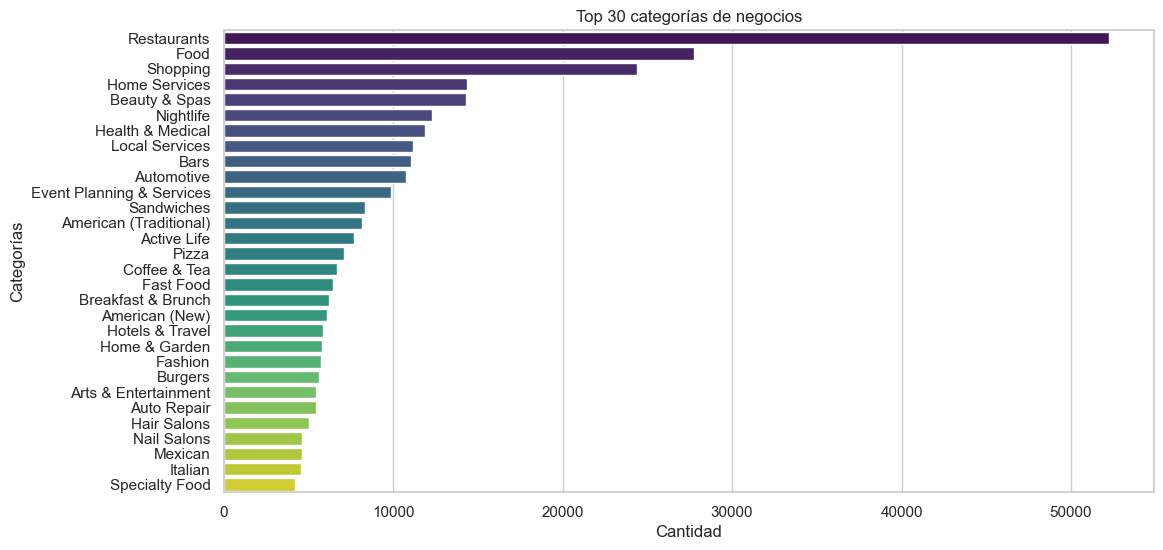

In [8]:
# Contar las categorías más comunes
df_business["categories"] = df_business["categories"].fillna("").apply(lambda x: x.split(", "))
categories = df_business["categories"].explode().value_counts().head(30)

# Visualizar las categorías más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=categories.values, y=categories.index, palette="viridis")
plt.title("Top 30 categorías de negocios")
plt.xlabel("Cantidad")
plt.ylabel("Categorías")
plt.show()

Conslusión:
La categoria que predomida en el df_business, es la relacionada a alimentación, restaurantes y comida, ocupando los dos primeros lugares, también se observan otras categorias relacionadas a la alimentación como son los sandwiches, pizza, comidad rápida, etc. En ese sentido nuestro análisis esta enfocado al análisis del sector alimentación específicamente nos enfocaremos en la categoría Restaurantes.


### Filtramos el dataframe business enfocando nuestro análisis al sector alimentación

In [9]:
# Realizamos un copy del Dataframe original
df_business1 = data_business.iloc[:, :14].copy()

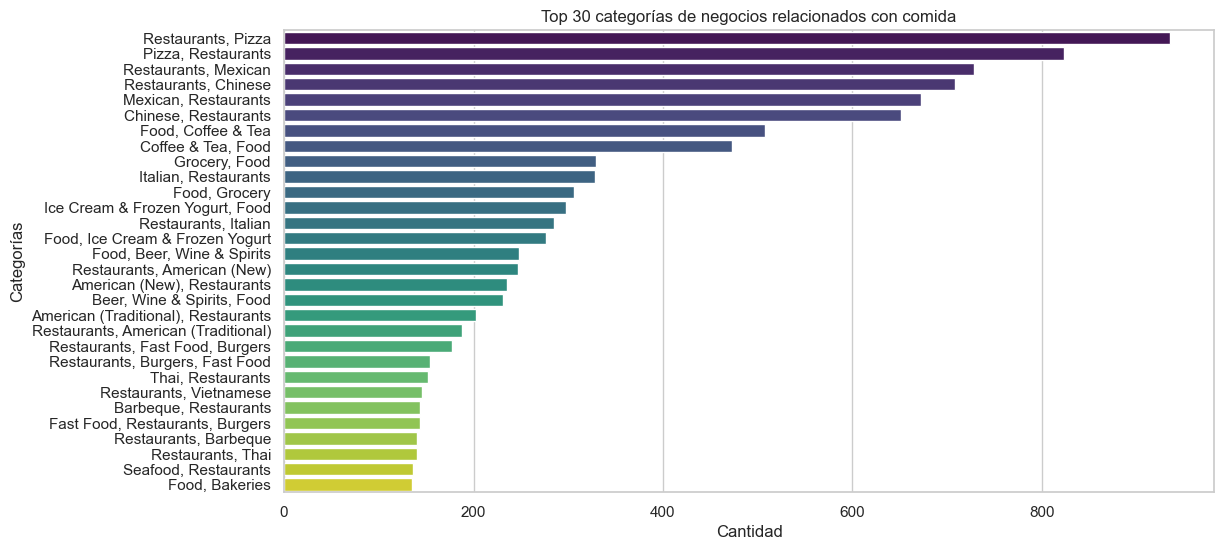

In [10]:
# Opción 1: Rellenar los valores nulos con una cadena vacía antes de aplicar la función
df_business1['categories'] = df_business1['categories'].fillna("")

# Opción 2: Filtrar los valores no nulos antes de aplicar la función (recomendado)
df_business_filtered = df_business1.dropna(subset=['categories'])  # Elimina filas con categorías nulas

# Crear la columna booleana para comida (utilizando el DataFrame filtrado)
df_business_filtered['is_food_related'] = df_business_filtered['categories'].apply(lambda x: any(word in x for word in ['Restaurants', 'Food', 'Pizza', 'Burgers', 'Sandwiches', 'Mexican', 'Italian', 'Chinese', 'Japanese', 'Thai', 'Indian', 'Coffee', 'Tea']))

# Filtrar los negocios relacionados con comida
df_food = df_business_filtered[df_business_filtered['is_food_related']]

# Contar las categorías más comunes de comida
categories_food = df_food["categories"].explode().value_counts().head(30)

# Visualizar las categorías más comunes de comida
plt.figure(figsize=(12, 6))
sns.barplot(x=categories_food.values, y=categories_food.index, palette="viridis")
plt.title("Top 30 categorías de negocios relacionados con comida")
plt.xlabel("Cantidad")
plt.ylabel("Categorías")
plt.show()

Conclusión:
- El gráfico muestra que Restaurants Pizza o Pizza, Resturants predomica como una de las principales categorías; segudio de Restaurants, Mexican y muchas otras combinaciones más como italiana, asiática, etc. Esto refleja la multiculturalidad de la población estadounidense y su gusto por diferentes sabores.
- Además la crecinente demanda por comida latina, hace que nuestro análsis se enfoque en restaurantes que brindan alimentos de origen latino, para ello se segmentará aún más el dataset. 

### Análisis de restaurantes latinos

Construimos un diccionario con las palabras claves asociadas a los restaurantes de tipo latino

In [11]:
# Diccionario de palabras clave asociadas a cada tipo de restaurante latino
categoria_restaurante = {
    'restaurante argentino': ['argentine', 'argentinian', 'argentinian restaurant'],
    'restaurante mexicano': ['mexican', 'mexican restaurant', 'burrito', 'taco', 'pozole', 'Oaxacan'],
    'restaurante colombiano': ['colombian', 'colombian restaurant'],
    'restaurante peruano': ['peruvian', 'peruvian restaurant'],
    'restaurante brasileño': ['brazilian', 'brazilian restaurant'],
    'restaurante cubano': ['cuban', 'cuban restaurant'],
    'restaurante venezolano': ['venezuelan', 'venezuelan restaurant'],
    'restaurante chileno': ['chilean', 'chilean restaurant'],
    'restaurante ecuatoriano': ['ecuadorian', 'ecuadorian restaurant'],
    'restaurante dominicano': ['dominican', 'dominican restaurant'],
    'restaurante centroamericano': ['honduran', 'guatemalan', 'nicaraguan', 'panamanian', 'salvadoran', 'costarican', 'costa rican restaurant', 'honduran restaurant'],
    'restaurante caribeño': ['caribbean', 'caribbean restaurant'],
    'restaurante latinoamericano': ['latin american food', 'latin american', 'south american', 'latin', 'hispanic', 'south american restaurant'],
    'restaurante boliviano': ['bolivian', 'bolivian restaurant'],
    'restaurante paraguayo': ['paraguayan', 'paraguayan restaurant'],
    'restaurante uruguayo': ['uruguayan', 'uruguayan restaurant'],
    'restaurante puertorriqueño': ['puerto rican', 'puerto rican restaurant']
}

# Función para categorizar los restaurantes
def categorizar_restaurante(categoria):
    if isinstance(categoria, str):  # Verificar que la categoría es una cadena
        for categoria_nombre, keywords in categoria_restaurante.items():
            if any(keyword.lower() in categoria.lower() for keyword in keywords):
                return categoria_nombre
    return 'otros'  # Si no coincide con ninguna categoría o no es cadena, clasificar como 'otros'

In [12]:
# Aplicar la función a la columna 'categories' para crear una nueva columna 'restaurante_categoria'
df_food['restaurante_categoria'] = df_food['categories'].apply(categorizar_restaurante)

In [13]:
# Verificar las primeras filas con la nueva columna
df_food.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,NaN,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None,True,otros
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",True,otros


In [14]:
# Análisis detallado del DataFrame
# 1. Contar el número de restaurantes por categoría
conteo_categorias = df_food['restaurante_categoria'].value_counts()
print("\nConteo por categoría:")
print(conteo_categorias)


Conteo por categoría:
restaurante_categoria
otros                          59474
restaurante mexicano            4611
restaurante caribeño             471
restaurante cubano               256
restaurante latinoamericano      204
restaurante brasileño             84
restaurante peruano               69
restaurante colombiano            59
restaurante venezolano            39
restaurante centroamericano       38
restaurante argentino             34
restaurante dominicano            28
Name: count, dtype: int64


In [15]:
# 2. Filtrar solo los restaurantes latinos para análisis adicional
restaurantes_latinos = df_food[df_food['restaurante_categoria'] != 'otros']

In [16]:
restaurantes_latinos.shape

(5893, 16)

In [17]:
restaurantes_latinos.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria
104,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Mexican, Restaurants",None,True,restaurante mexicano
153,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Tru...","Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,restaurante mexicano


In [18]:
restaurantes_latinos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5893 entries, 104 to 150336
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   business_id            5893 non-null   object
 1   name                   5893 non-null   object
 2   address                5893 non-null   object
 3   city                   5893 non-null   object
 4   state                  5893 non-null   object
 5   postal_code            5893 non-null   object
 6   latitude               5893 non-null   object
 7   longitude              5893 non-null   object
 8   stars                  5893 non-null   object
 9   review_count           5893 non-null   object
 10  is_open                5893 non-null   object
 11  attributes             5798 non-null   object
 12  categories             5893 non-null   object
 13  hours                  5068 non-null   object
 14  is_food_related        5893 non-null   bool  
 15  restaurante_categoria 

In [19]:
# Verificar valores nulos
nulos_df = restaurantes_latinos.isnull().sum()
print("Valores faltantes por columna:")
print(nulos_df[nulos_df > 0])

Valores faltantes por columna:
attributes     95
hours         825
dtype: int64


Imputamos los valores nulos

In [20]:
restaurantes_latinos['attributes'] = restaurantes_latinos['attributes'].fillna('Desconocido')
restaurantes_latinos['hours'] = restaurantes_latinos['hours'].fillna('No Data')

Las columnas: latitude, longitude, stars, y review_count actualmente son de tipo object, se convertirán en numéricos

In [21]:
restaurantes_latinos['latitude'] = pd.to_numeric(restaurantes_latinos['latitude'], errors='coerce')
restaurantes_latinos['longitude'] = pd.to_numeric(restaurantes_latinos['longitude'], errors='coerce')
restaurantes_latinos['stars'] = pd.to_numeric(restaurantes_latinos['stars'], errors='coerce')
restaurantes_latinos['review_count'] = pd.to_numeric(restaurantes_latinos['review_count'], errors='coerce')

Duplicados, si hay se elimina

In [22]:
restaurantes_latinos = restaurantes_latinos.drop_duplicates(subset='business_id')

In [23]:
restaurantes_latinos.shape

(5893, 16)

In [24]:
restaurantes_latinos.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria
104,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Mexican, Restaurants",No Data,True,restaurante mexicano
153,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Tru...","Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,restaurante mexicano


Se ha Observado que las columnas: 'city' y 'state' no se corresponden por lo que se crea un función que asigne en una nueva columna el 'estado' al cual corresponde la ciudad.

In [25]:
# Creamos una lista con las ciudades únicas de los datos de restarurantes_latinos
lista_array = restaurantes_latinos['city'].unique()

lista_ciudades = pd.DataFrame(data=lista_array, columns=['ciudad'])
lista_ciudades.head(10)

,ciudad
0,Wilmington
1,Largo
2,Nashville
3,Philadelphia
4,New Orleans
5,Hermitage
6,Odessa
7,Horsham
8,Brownsburg
9,Isla Vista


In [26]:
lista_ciudades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ciudad  441 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB


In [27]:
# Guardamos lista_ciudade_yelp
lista_ciudades.to_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/lista_ciudades_yelp.csv', index=False)
#D:\2024\HenryData\PF\Datos_Crudos\yelp\df_new

In [28]:
from geopy.geocoders import Nominatim
import re

# Lista de estados válidos (ajusta según tus necesidades)
lista_estados = [
    "Alabama", "Alaska", "Arizona", "Arkansas",
    "California", "Colorado", "Connecticut", "Delaware",
    "Florida", "Georgia", "Hawaii", "Idaho",
    "Illinois", "Indiana", "Iowa", "Kansas",
    "Kentucky", "Louisiana", "Maine", "Maryland",
    "Massachusetts", "Michigan", "Minnesota", "Mississippi",
    "Missouri", "Montana", "Nebraska", "Nevada",
    "New Hampshire", "New Jersey", "New Mexico", "New York",
    "North Carolina", "North Dakota", "Ohio", "Oklahoma",
    "Oregon", "Pennsylvania", "Rhode Island", "South Carolina",
    "South Dakota", "Tennessee", "Texas", "Utah",
    "Vermont", "Virginia", "Washington", "West Virginia",
    "Wisconsin", "Wyoming"
]

# Inicializar el geocodificador
geolocator = Nominatim(user_agent="my_geocoder")

# Función para obtener el estado a partir de una ciudad
def get_state(city):
    try:
        location = geolocator.geocode(city)
        if location:
            address_parts = location.address.split(', ')
            for part in address_parts:
                if part in lista_estados:
                    return part
            return 'Estado no válido'
        else:
            return 'Estado no encontrado'
    except Exception as e:
        print(f"Error al geocodificar {city}: {e}")
        return 'Error'

# Aplicar la función a cada fila y crear una nueva columna
lista_ciudades['estado'] = lista_ciudades['ciudad'].apply(get_state)

lista_ciudades.head()

,ciudad,estado
0,Wilmington,Delaware
1,Largo,Florida
2,Nashville,Tennessee
3,Philadelphia,Pennsylvania
4,New Orleans,Louisiana


In [29]:
lista_ciudades['estado'].unique()

array(['Delaware', 'Florida', 'Tennessee', 'Pennsylvania', 'Louisiana',
       'Missouri', 'Estado no válido', 'Indiana', 'California', 'Arizona',
       'Nevada', 'New Jersey', 'Idaho', 'Illinois', 'New York',
       'Wisconsin', 'Mississippi', 'Vermont', 'North Carolina',
       'Maryland', 'Minnesota', 'Oklahoma', 'Iowa', 'Ohio', 'Texas',
       'Kansas', 'Connecticut', 'Colorado', 'Michigan', 'Massachusetts',
       'Estado no encontrado', 'Washington', 'Virginia', 'South Carolina',
       'Georgia', 'West Virginia', 'Rhode Island', 'Wyoming', 'Alabama'],
      dtype=object)

In [30]:
lista_ciudades = lista_ciudades.rename(columns={'ciudad':'city'})

In [31]:
restaurantes_latinos = pd.merge(restaurantes_latinos, lista_ciudades, on='city', how= 'inner')

In [32]:
restaurantes_latinos.shape

(5893, 17)

In [33]:
restaurantes_latinos.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,is_food_related,restaurante_categoria,estado
0,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"{'BusinessAcceptsCreditCards': 'True', 'HasTV'...","Mexican, Restaurants",No Data,True,restaurante mexicano,Delaware
1,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"{'RestaurantsPriceRange2': '1', 'Caters': 'Tru...","Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,restaurante mexicano,Florida
2,X_E7U2lVNEwbH_gpOBmAHQ,Cerveza Jack's,135 2nd Ave N,Nashville,ID,37201,36.162799,-86.776016,4.0,182,1,"{'GoodForDancing': 'True', 'Smoking': 'u'no'',...","Nightlife, Restaurants, Bars, Mexican","{'Monday': '0:0-0:0', 'Wednesday': '11:0-22:0'...",True,restaurante mexicano,Tennessee
3,_T0cPZE2ZJOTTlYYKMP64Q,Brown Sugar Bakery & Cafe,219 S 52nd St,Philadelphia,AB,19139,39.956396,-75.225378,4.5,66,1,"{'Caters': 'False', 'Alcohol': 'u'none'', 'Res...","Cupcakes, Caribbean, Restaurants, Trinidadian,...","{'Monday': '9:0-22:0', 'Tuesday': '9:0-22:0', ...",True,restaurante caribeño,Pennsylvania
4,W57cR9a7XP6RX56MSWHJJA,Las Margaritas,514 S Rampart St,New Orleans,FL,70163,29.950290,-90.074887,3.5,58,0,"{'GoodForKids': 'True', 'OutdoorSeating': 'Tru...","Mexican, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",True,restaurante mexicano,Louisiana


In [34]:
restaurantes_latinos = restaurantes_latinos.rename(columns={'estado': 'state_name'})

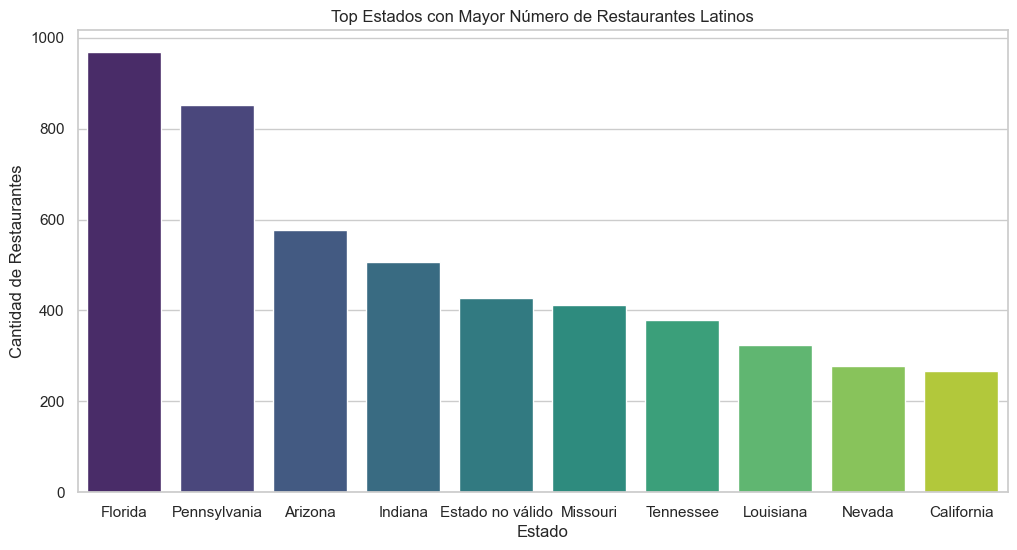

In [35]:
# Contar restaurantes por estado
restaurantes_por_estado = restaurantes_latinos['state_name'].value_counts().reset_index()
restaurantes_por_estado.columns = ['state_name', 'count']

# Visualizar
plt.figure(figsize=(12, 6))
sns.barplot(data=restaurantes_por_estado.head(10), x='state_name', y='count', palette='viridis')
plt.title("Top Estados con Mayor Número de Restaurantes Latinos")
plt.xlabel("Estado")
plt.ylabel("Cantidad de Restaurantes")
plt.show()

Análisis Descriptivo de las columnas numéricas

In [36]:
print(restaurantes_latinos[['stars', 'review_count']].describe())

             stars  review_count
count  5893.000000    5893.00000
mean      3.605719      89.53606
std       0.841841     171.07196
min       1.000000       5.00000
25%       3.000000      14.00000
50%       3.500000      36.00000
75%       4.000000      92.00000
max       5.000000    3834.00000


Distribución de la variable is_open:

In [37]:
restaurantes_latinos['is_open'].value_counts()

is_open
1    4142
0    1751
Name: count, dtype: int64

Ciudades y estados más frecuentes

In [38]:
print('Ciudades más Frecuentes')
print(restaurantes_latinos['city'].value_counts().head(10))
print('Estados más frecuentes')
print(restaurantes_latinos['state_name'].value_counts().head(10))

Ciudades más Frecuentes
city
Tucson           544
Tampa            520
Philadelphia     491
Indianapolis     433
Nashville        331
Reno             201
New Orleans      192
Saint Louis      157
Santa Barbara    135
Boise            114
Name: count, dtype: int64
Estados más frecuentes
state_name
Florida             968
Pennsylvania        851
Arizona             576
Indiana             507
Estado no válido    428
Missouri            412
Tennessee           379
Louisiana           325
Nevada              277
California          267
Name: count, dtype: int64


Distribución de categorías: Observamos que la categoría Mexicana es la mas polular

In [39]:
from collections import Counter
categorias = restaurantes_latinos['categories'].str.split(', ').explode()
print(Counter(categorias).most_common(10))

[('Restaurants', 5878), ('Mexican', 4600), ('Food', 1276), ('Tacos', 1020), ('Fast Food', 902), ('Latin American', 810), ('Nightlife', 788), ('Breakfast & Brunch', 787), ('Bars', 769), ('Tex-Mex', 769)]


Relación entre calificación y cantidad de reseñas

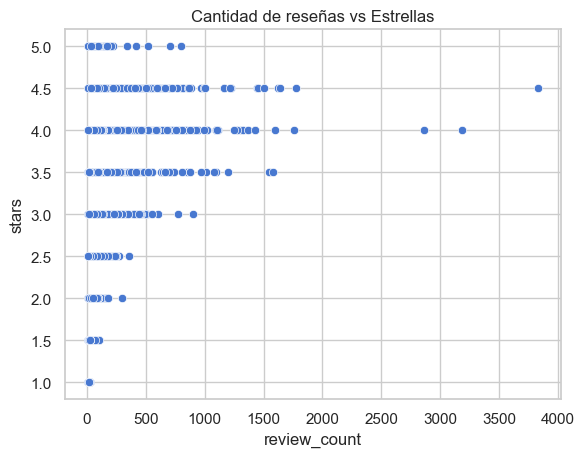

In [40]:
sns.scatterplot(data=restaurantes_latinos, x='review_count', y='stars')
plt.title('Cantidad de reseñas vs Estrellas')
plt.show()

Restaurantes abiertos vs cerrados (is_open) y calificación:

Text(0.5, 1.0, 'Comparación de calificaciones entre abiertos y cerrados')

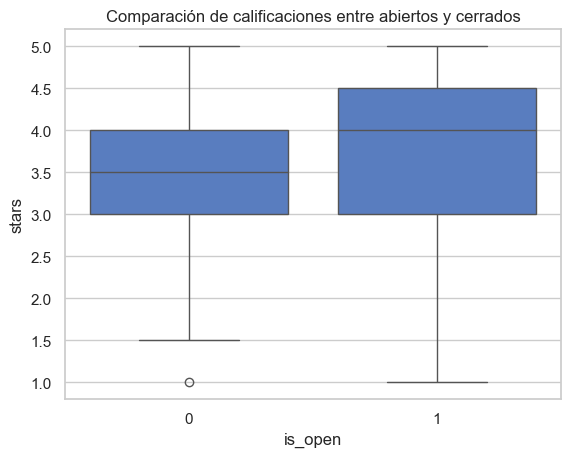

In [41]:
sns.boxplot(data=restaurantes_latinos, x='is_open', y='stars')
plt.title('Comparación de calificaciones entre abiertos y cerrados')

Distribución geográfica de los restaurantes:

In [42]:
import os
import plotly.express as px

In [43]:
# Obtener el token de la variable de entorno
mapbox_token = os.environ.get('MAPBOX_ACCESS_TOKEN')

# Configurar el token en Plotly
px.set_mapbox_access_token(mapbox_token)

In [44]:
# Asegúrate de que las columnas 'latitude' y 'longitude' son numéricas
restaurantes_latinos['latitude'] = pd.to_numeric(restaurantes_latinos['latitude'], errors='coerce')
restaurantes_latinos['longitude'] = pd.to_numeric(restaurantes_latinos['longitude'], errors='coerce')

# Crear el mapa con markers
fig = px.scatter_mapbox(restaurantes_latinos,
                        lat="latitude",
                        lon="longitude",
                        hover_name="name",
                        hover_data=["city", "stars"],
                        zoom=5,
                        title="Restaurantes Latinos en EE.UU.")

# Configuración del estilo del mapa
fig.update_layout(mapbox_style="open-street-map")
fig.show()

Análisis de texto (columnas attributes y categories)

In [45]:

# Asegurarse de que la columna 'attributes' no tenga valores nulos
df = restaurantes_latinos.copy()  # Crear una copia de seguridad
df['attributes'] = df['attributes'].fillna('{}')  # Reemplazar NaN con diccionario vacío

# Verificar la transformación
print(df['attributes'].head(10))

0    {'BusinessAcceptsCreditCards': 'True', 'HasTV'...
1    {'RestaurantsPriceRange2': '1', 'Caters': 'Tru...
2    {'GoodForDancing': 'True', 'Smoking': 'u'no'',...
3    {'Caters': 'False', 'Alcohol': 'u'none'', 'Res...
4    {'GoodForKids': 'True', 'OutdoorSeating': 'Tru...
5    {'GoodForKids': 'True', 'RestaurantsReservatio...
6    {'BusinessAcceptsCreditCards': 'True', 'Alcoho...
7    {'RestaurantsGoodForGroups': 'True', 'Restaura...
8    {'RestaurantsPriceRange2': '2', 'RestaurantsGo...
9    {'BusinessAcceptsCreditCards': 'True', 'Restau...
Name: attributes, dtype: object


In [46]:
from pandas import json_normalize

# Expandir la columna 'attributes'
attributes_df = json_normalize(df['attributes'])

# Unir las nuevas columnas de atributos al DataFrame original
df_expanded = pd.concat([df.drop(columns='attributes'), attributes_df], axis=1)

In [47]:
# Verificar el DataFrame resultante
df_expanded.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,is_food_related,restaurante_categoria,state_name,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsTakeOut,Caters,WiFi,RestaurantsAttire,NoiseLevel,BusinessParking,BikeParking,Alcohol,RestaurantsGoodForGroups,GoodForMeal,RestaurantsDelivery,Ambience,DriveThru,RestaurantsTableService,GoodForDancing,Smoking,CoatCheck,DogsAllowed,BestNights,Music,HappyHour,ByAppointmentOnly,BYOB,Corkage,BusinessAcceptsBitcoin,WheelchairAccessible,BYOBCorkage,DietaryRestrictions,AgesAllowed,Open24Hours,RestaurantsCounterService
0,Dy91wdWkwtI_qgjAIZ0Niw,Taqueria Los Primos,3322 Old Capitol Trl,Wilmington,IN,19808,39.732089,-75.625673,4.0,23,1,"Mexican, Restaurants",No Data,True,restaurante mexicano,Delaware,True,True,False,False,True,1,True,False,u'no',u'casual',u'quiet',"{'garage': False, 'street': False, 'validated'...",False,u'none',True,"{u'breakfast': False, u'brunch': False, u'lunc...",True,"{u'divey': True, u'hipster': False, u'casual':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,restaurante mexicano,Florida,True,True,True,False,True,1,True,True,'free','casual','average',"{'garage': False, 'street': False, 'validated'...",True,'none',False,"{'dessert': False, 'latenight': False, 'lunch'...",True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BusinessAcceptsCreditCards
True     4862
False     215
None        1
Name: count, dtype: int64


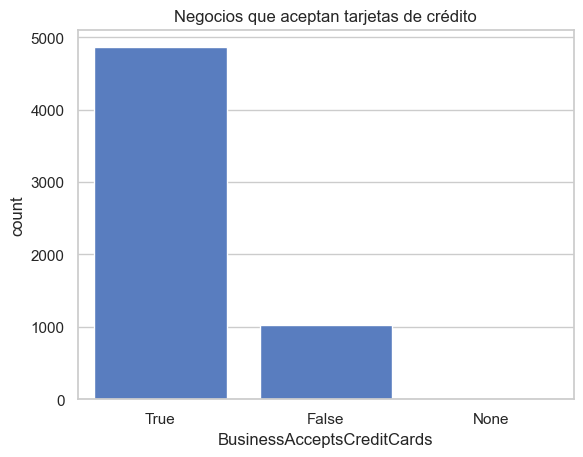

In [48]:
# Contar valores en la columna 'BusinessAcceptsCreditCards'
print(df_expanded['BusinessAcceptsCreditCards'].value_counts())

# Reemplazar 'None' o NaN con 'False' para un análisis más claro
df_expanded['BusinessAcceptsCreditCards'] = df_expanded['BusinessAcceptsCreditCards'].fillna('False')

# Gráfico de barras 
sns.countplot(data=df_expanded, x='BusinessAcceptsCreditCards')
plt.title("Negocios que aceptan tarjetas de crédito")
plt.show()

In [49]:
# Conteo de 'HasTV' y otros atributos
print(df_expanded['HasTV'].value_counts())
print(df_expanded['WiFi'].value_counts())

HasTV
True     3991
False     834
None        1
Name: count, dtype: int64
WiFi
u'no'      1422
u'free'    1307
'no'        856
'free'      493
u'paid'      19
'paid'       13
None          3
Name: count, dtype: int64


Cargaremos el Dataset de los estados con mayor población latina, con el objetivo que unir al df_expanded

In [51]:
states = pd.read_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/states.csv')

In [52]:
states.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state_id             558 non-null    int64  
 1   state_name           558 non-null    object 
 2   abbreviation         558 non-null    object 
 3   county_name          558 non-null    object 
 4   total_population     558 non-null    int64  
 5   hispanic_population  558 non-null    int64  
 6   avg_income           558 non-null    float64
dtypes: float64(1), int64(3), object(3)
memory usage: 30.6+ KB


In [53]:
restaurantes_latinos_filtrados = pd.merge(df_expanded, states, on='state_name', how='inner')

In [54]:
restaurantes_latinos_filtrados.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,is_food_related,restaurante_categoria,state_name,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsTakeOut,Caters,WiFi,RestaurantsAttire,NoiseLevel,BusinessParking,BikeParking,Alcohol,RestaurantsGoodForGroups,GoodForMeal,RestaurantsDelivery,Ambience,DriveThru,RestaurantsTableService,GoodForDancing,Smoking,CoatCheck,DogsAllowed,BestNights,Music,HappyHour,ByAppointmentOnly,BYOB,Corkage,BusinessAcceptsBitcoin,WheelchairAccessible,BYOBCorkage,DietaryRestrictions,AgesAllowed,Open24Hours,RestaurantsCounterService,state_id,abbreviation,county_name,total_population,hispanic_population,avg_income
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,restaurante mexicano,Florida,True,True,True,False,True,1,True,True,'free','casual','average',"{'garage': False, 'street': False, 'validated'...",True,'none',False,"{'dessert': False, 'latenight': False, 'lunch'...",True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FL,Alachua,253231,22837,46780.82
1,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,10160 Ulmerton Rd,Largo,IN,33771,27.894167,-82.779866,3.0,19,1,"Mexican, Fast Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '10:45-22:0',...",True,restaurante mexicano,Florida,True,True,True,False,True,1,True,True,'free','casual','average',"{'garage': False, 'street': False, 'validated'...",True,'none',False,"{'dessert': False, 'latenight': False, 'lunch'...",True,"{'touristy': False, 'hipster': False, 'romanti...",True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,FL,Baker,27537,620,56274.50


In [55]:
restaurantes_latinos_filtrados.shape

(117782, 59)

Eliminamos los duplciados por la columna 'business_id'

In [56]:
restaurantes_latinos_filtrados = restaurantes_latinos_filtrados.drop_duplicates(subset='business_id')

In [57]:
restaurantes_latinos_filtrados.shape

(2015, 59)

In [58]:
restaurantes_latinos_filtrados['state_name'].unique()

array(['Florida', 'California', 'Arizona', 'Illinois', 'New York',
       'Texas'], dtype=object)

In [59]:
nuevo_orden = ['business_id', 'name', 'restaurante_categoria','address', 'city', 'state_id', 'state_name', 'abbreviation', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open', 'categories','BusinessAcceptsCreditCards','HasTV','OutdoorSeating', 'RestaurantsTakeOut','WiFi','RestaurantsAttire','NoiseLevel']
restaurantes_latinos_filtrados = restaurantes_latinos_filtrados.reindex(columns=nuevo_orden)

In [60]:
restaurantes_latinos_filtrados.head(2)

,business_id,name,restaurante_categoria,address,city,state_id,state_name,abbreviation,postal_code,latitude,longitude,stars,review_count,is_open,categories,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsTakeOut,WiFi,RestaurantsAttire,NoiseLevel
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,restaurante mexicano,10160 Ulmerton Rd,Largo,1,Florida,FL,33771,27.894167,-82.779866,3.0,19,1,"Mexican, Fast Food, Restaurants",True,True,True,True,'free','casual','average'
67,4xhGQGdGqU60BIznBjqnuA,California Tacos and Taproom,restaurante mexicano,956 Embarcadero Del Norte,Isla Vista,2,California,CA,93117,34.411555,-119.855077,4.0,49,0,"Mexican, Beer Bar, Bars, Sports Bars, Nightlif...",True,True,True,True,u'free',NaN,NaN


In [61]:
restaurantes_latinos_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2015 entries, 0 to 117715
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 2015 non-null   object 
 1   name                        2015 non-null   object 
 2   restaurante_categoria       2015 non-null   object 
 3   address                     2015 non-null   object 
 4   city                        2015 non-null   object 
 5   state_id                    2015 non-null   int64  
 6   state_name                  2015 non-null   object 
 7   abbreviation                2015 non-null   object 
 8   postal_code                 2015 non-null   object 
 9   latitude                    2015 non-null   float64
 10  longitude                   2015 non-null   float64
 11  stars                       2015 non-null   float64
 12  review_count                2015 non-null   int64  
 13  is_open                     2015 non

In [62]:
categorical_columns = ['NoiseLevel', 'WiFi', 'HasTV', 'OutdoorSeating', 'BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'RestaurantsAttire']
for col in categorical_columns:
    restaurantes_latinos_filtrados[col].fillna('Desconocido', inplace=True)

In [90]:
print(restaurantes_latinos_filtrados.isnull().sum())

business_id                   0
name                          0
restaurante_categoria         0
address                       0
city                          0
state_id                      0
state_name                    0
abbreviation                  0
postal_code                   0
latitude                      0
longitude                     0
stars                         0
review_count                  0
is_open                       0
categories                    0
BusinessAcceptsCreditCards    0
HasTV                         0
OutdoorSeating                0
RestaurantsTakeOut            0
WiFi                          0
RestaurantsAttire             0
NoiseLevel                    0
dtype: int64


In [63]:
# Eliminar las comillas de los valores de la columna NoiseLevel
restaurantes_latinos_filtrados['NoiseLevel'] = restaurantes_latinos_filtrados['NoiseLevel'].str.replace("'", "")
restaurantes_latinos_filtrados['RestaurantsAttire'] = restaurantes_latinos_filtrados['RestaurantsAttire'].str.replace("'", "")
restaurantes_latinos_filtrados['WiFi'] = restaurantes_latinos_filtrados['WiFi'].str.replace("'", " ")

In [64]:
restaurantes_latinos_filtrados.head(2)

,business_id,name,restaurante_categoria,address,city,state_id,state_name,abbreviation,postal_code,latitude,longitude,stars,review_count,is_open,categories,BusinessAcceptsCreditCards,HasTV,OutdoorSeating,RestaurantsTakeOut,WiFi,RestaurantsAttire,NoiseLevel
0,aNtKyc2rr-uK5cqzY9TVQQ,Chipotle Mexican Grill,restaurante mexicano,10160 Ulmerton Rd,Largo,1,Florida,FL,33771,27.894167,-82.779866,3.0,19,1,"Mexican, Fast Food, Restaurants",True,True,True,True,free,casual,average
67,4xhGQGdGqU60BIznBjqnuA,California Tacos and Taproom,restaurante mexicano,956 Embarcadero Del Norte,Isla Vista,2,California,CA,93117,34.411555,-119.855077,4.0,49,0,"Mexican, Beer Bar, Bars, Sports Bars, Nightlif...",True,True,True,True,u free,Desconocido,Desconocido


Manejo de valores 'None' en las columnas:

In [65]:
columns_to_replace = [
    'NoiseLevel', 
    'RestaurantsAttire', 
    'WiFi', 
    'BusinessAcceptsCreditCards', 
    'HasTV', 
    'OutdoorSeating', 
    'RestaurantsTakeOut'
]

# Reemplazar 'None' con 'Desconocido' para las columnas especificadas
restaurantes_latinos_filtrados[columns_to_replace] = restaurantes_latinos_filtrados[columns_to_replace].replace('None', 'Desconocido')

In [66]:
restaurantes_latinos_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2015 entries, 0 to 117715
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 2015 non-null   object 
 1   name                        2015 non-null   object 
 2   restaurante_categoria       2015 non-null   object 
 3   address                     2015 non-null   object 
 4   city                        2015 non-null   object 
 5   state_id                    2015 non-null   int64  
 6   state_name                  2015 non-null   object 
 7   abbreviation                2015 non-null   object 
 8   postal_code                 2015 non-null   object 
 9   latitude                    2015 non-null   float64
 10  longitude                   2015 non-null   float64
 11  stars                       2015 non-null   float64
 12  review_count                2015 non-null   int64  
 13  is_open                     2015 non

Guardar archivo filtrado

In [85]:
restaurantes_latinos_filtrados.to_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/restaurantes_latinos_filtrados.csv', index=False)

-----

Recortamos el dataset 'review'

In [67]:
# Ruta al archivo JSON
file_path = 'D:/2024/HenryData/PF/Datos_Crudos/yelp/review.json'

# Abrir el archivo especificando la codificación
with open(file_path, 'r', encoding='utf-8') as file:
    data = [json.loads(line) for line in file]

In [68]:
# Convertir los datos a un DataFrame de pandas
df_review = pd.DataFrame(data)

In [69]:
df_review.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


In [70]:
df_review['business_id'] = df_review['business_id'].astype(str)
restaurantes_latinos_filtrados['business_id'] = restaurantes_latinos_filtrados['business_id'].astype(str)

In [71]:
# Filtra df_review para incluir solo los 'business_id' presentes en restaurantes_latinos_filtrados
df_review_filtered = df_review[df_review['business_id'].isin(restaurantes_latinos_filtrados['business_id'])]

In [72]:
# Verifica el tamaño del DataFrame original y el filtrado
print(f"Tamaño original de df_review: {df_review.shape}")
print(f"Tamaño de df_review filtrado: {df_review_filtered.shape}")

Tamaño original de df_review: (6990280, 9)
Tamaño de df_review filtrado: (209469, 9)


In [73]:
# Muestra las primeras filas del DataFrame filtrado
df_review_filtered.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
14,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4.0,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05
47,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12
73,PDHRlnEdkEcwATry4w71PQ,UsBxLh14sUpO8SdeqIiGOA,Wy8Hswf2cLQGRZN6armkag,1.0,1,0,0,"If I could give it a zero, I would. I order a ...",2011-08-24 23:07:08
93,onlgwy5qGDEzddsrnIvtWg,pYXeL0RCqus2IfhthYCOyA,W7NxQw8UYFR0HLPrI08tvw,4.0,0,0,0,Don't know what it is but If my tummy's feelin...,2012-02-01 14:21:25
147,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5.0,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04


In [74]:
# Selecciona las columnas necesarias de restaurantes_latinos_filtrados
columns_to_add = ['business_id', 'name', 'restaurante_categoria', 'state_name']

# Realiza el merge
df_review_filtered = df_review_filtered.merge(
    restaurantes_latinos_filtrados[columns_to_add],
    on='business_id',
    how='inner'  # Unión basada en los 'business_id' comunes
)

In [75]:
# Verifica el tamaño y las primeras filas del DataFrame
print(f"Tamaño después del merge: {df_review_filtered.shape}")


Tamaño después del merge: (209469, 12)


In [76]:
df_review_filtered.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,restaurante_categoria,state_name
0,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4.0,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05,BK Tacos,restaurante mexicano,Arizona
1,TcCcHzc3L6Aboq3DteEfZA,OuatwND396ZQxm2zK8WlUQ,jNL5KUPz2-tHUJM__ysSaw,1.0,1,0,0,If you want to pay for everything a la carte t...,2014-08-24 20:14:12,El Chicanito Mexican Restaurant,restaurante mexicano,Florida


Revisamos los nulos y duplicados del dataset filtrado

In [77]:
# Valores nulos por columna
print("Valores nulos por columna:")
print(df_review_filtered.isnull().sum())

# Filas duplicadas
print(f"Filas duplicadas: {df_review_filtered.duplicated().sum()}")

Valores nulos por columna:
review_id                0
user_id                  0
business_id              0
stars                    0
useful                   0
funny                    0
cool                     0
text                     0
date                     0
name                     0
restaurante_categoria    0
state_name               0
dtype: int64
Filas duplicadas: 0


Análisis del Dataset Filtrado

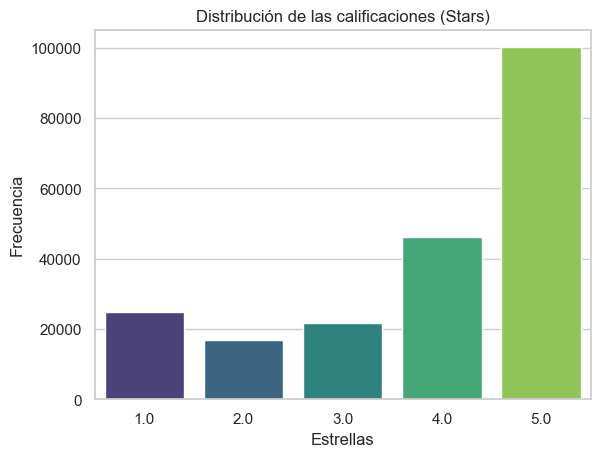

In [78]:
# Distribución de la columna 'stars'
sns.countplot(data=df_review_filtered, x='stars', palette='viridis')
plt.title("Distribución de las calificaciones (Stars)")
plt.xlabel("Estrellas")
plt.ylabel("Frecuencia")
plt.show()

Negocios más reseñados:
 name
Los Agaves                5192
Columbia Restaurant       3974
Chipotle Mexican Grill    3050
El Charro Cafe            2627
Taco Bell                 2261
Taco Bus                  2257
Lolis Mexican Cravings    1882
La Super-Rica Taqueria    1802
Lilly's Tacos             1773
Capital Tacos             1630
Name: count, dtype: int64


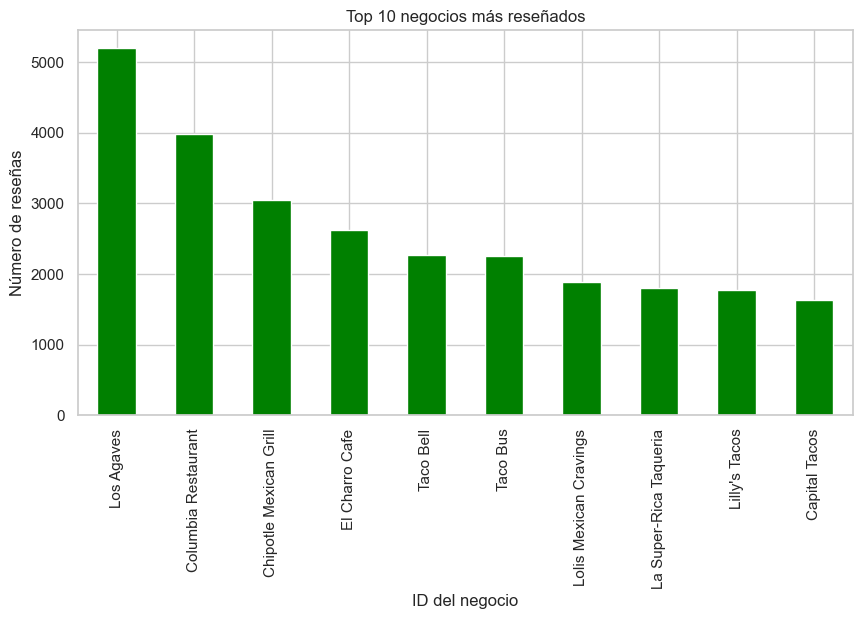

In [80]:
# Negocios con más reseñas
top_businesses = df_review_filtered['name'].value_counts().head(10)
print("Negocios más reseñados:\n", top_businesses)

# Visualizar
top_businesses.plot(kind='bar', figsize=(10, 5), color='green')
plt.title("Top 10 negocios más reseñados")
plt.xlabel("ID del negocio")
plt.ylabel("Número de reseñas")
plt.show()

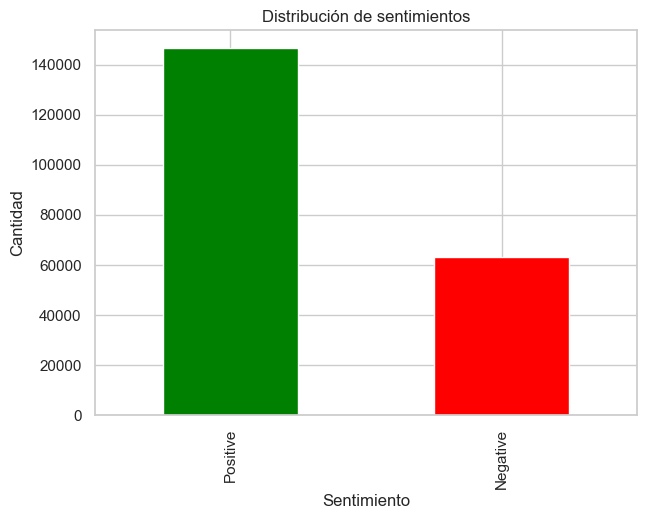

In [82]:
# Clasificar reseñas como positivas o negativas basadas en 'stars'
df_review_filtered['sentiment'] = df_review_filtered['stars'].apply(lambda x: 'Positive' if x >= 4 else 'Negative')

# Conteo de sentimientos
sentiment_counts = df_review_filtered['sentiment'].value_counts()

# Visualización
sentiment_counts.plot(kind='bar', figsize=(7, 5), color=['green', 'red'])
plt.title("Distribución de sentimientos")
plt.xlabel("Sentimiento")
plt.ylabel("Cantidad")
plt.show()

In [83]:
# Tomamos una muestra aleatoria de 10000 filas
muestra = df_review_filtered.sample(n=10000, random_state=42) 

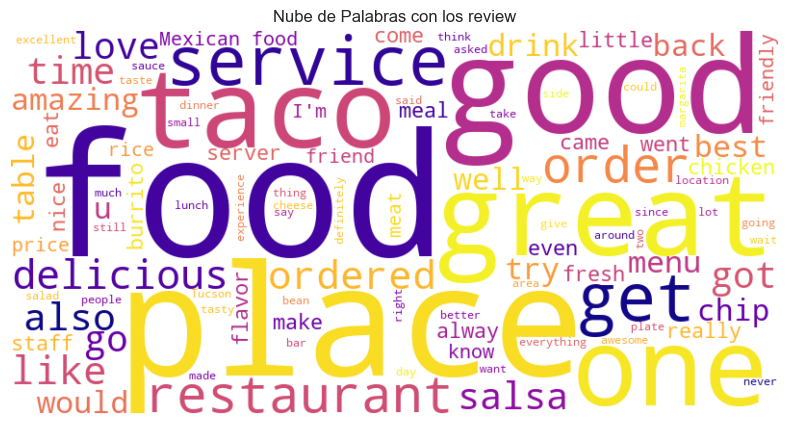

In [84]:
# Concatenamos todas las descripciones del título en una sola cadena
texto_nube = ' '.join(muestra['text'])

# Creamos la nube de palabras
nube_palabras = WordCloud(stopwords=stop_words, background_color='white', max_words=100, width=800, height=400, colormap='plasma').generate(texto_nube)

# Mostramos la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(nube_palabras, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras con los review')
plt.show()

Guardamos el Dataset Filtrado 

In [86]:
df_review_filtered.to_csv('D:/2024/HenryData/PF/Datos_Crudos/yelp/df_new/df_review_filtered.csv', index=False)
